## Objectives

It is required to find a model capable of making prediction for both products with acceptable accuracy 30-40 days ahead.

The client evaluates the quality of forecasting by the metric  $$buying\,score = (1 + \hat{y})/(1 + y)$$

Overbuying $$buying\,score > 1$$ is more harmful than underbuying $$buying\,score < 1$$  

## Data overview

In [1]:
# import libraries (Python 3.9.7)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# set global parameters 
sns.set(style='darkgrid') 
pd.set_option('precision', 2)
warnings.filterwarnings('ignore')
torch.manual_seed(777);

In [3]:
# define path to directory
path1 = 'C:/TestProjects/Byndyusoft/clean_sales_fabric_42_sku_13653_warehouse_-1.csv'
path2 = 'C:/TestProjects/Byndyusoft/clean_sales_fabric_96_sku_265_warehouse_1.csv'

In [4]:
# read in csv files
df1 = pd.read_csv(path1, index_col=[0], parse_dates=[0])
df2 = pd.read_csv(path2, index_col=[0], parse_dates=[0])

In [5]:
# print out info about df1
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2018-01-11 to 2017-07-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   15 non-null     int64
dtypes: int64(1)
memory usage: 240.0 bytes


In [6]:
# print out info about df2
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174 entries, 2017-10-30 to 2018-08-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   174 non-null    int64
dtypes: int64(1)
memory usage: 2.7 KB


In [7]:
# check for NaN values
print(df1.isnull().values.any())
print(df2.isnull().values.any())

False
False


In [8]:
# check for monotonic increasing series 
print(df1.index.is_monotonic)
print(df2.index.is_monotonic)

False
False


In [9]:
# show 5 rows in df1
display(df1.head())

,count
date,
2018-01-11,1
2017-12-07,1
2017-11-14,1
2018-04-08,1
2017-04-24,1


In [10]:
# show 5 rows in df2
display(df2.head())

,count
date,
2017-10-30,3
2017-10-30,1
2017-10-27,1
2017-10-22,1
2017-10-13,1


## Pre-processing

In [11]:
# function for plotting multiple graphs
def plot_graphs(df1, df2, title):
    fig, axs = plt.subplots(2, figsize=(12, 6))
    fig.suptitle(title, fontsize=15)
    axs[0].set_title('1st item', fontsize=13)
    axs[1].set_title('2nd item', fontsize=13)
    axs[0].plot(df1.reset_index()['date'], df1['count'])
    axs[1].plot(df2.reset_index()['date'], df2['count'])

    for ax in axs.flat:
        ax.set(xlabel='date of sales', ylabel='count')

    plt.tight_layout()

In [12]:
# reset indeces
df1 = df1.reset_index()
df2 = df2.reset_index()

In [13]:
# convert to date
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

In [14]:
# sort out by date
df1 = df1.sort_values(by='date', ascending=True).reset_index(drop=True).set_index('date')
df2 = df2.sort_values(by='date', ascending=True).reset_index(drop=True).set_index('date')

In [15]:
# show 5 rows in df1
display(df1.head())

,count
date,
2017-04-04,1
2017-04-24,1
2017-06-05,1
2017-07-02,1
2017-11-13,1


In [16]:
# show 5 rows in df2
display(df2.head())

,count
date,
2015-07-13,1
2015-08-18,1
2015-09-04,2
2015-09-19,1
2015-10-17,1


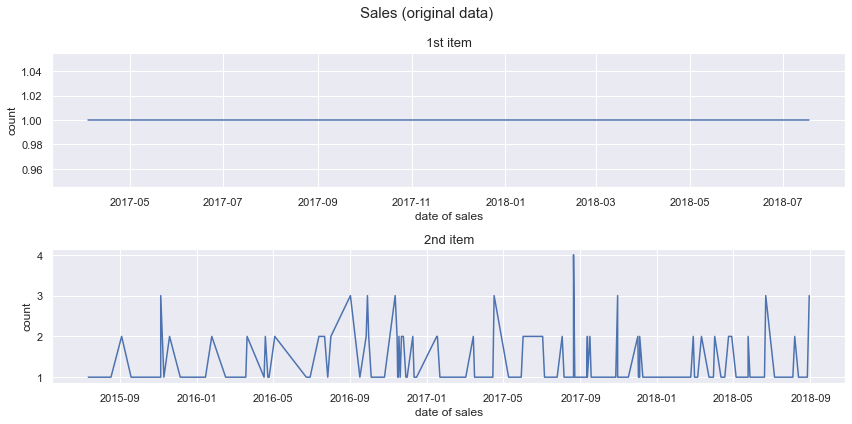

In [17]:
# plot original data
plot_graphs(df1=df1, df2=df2, title='Sales (original data)')

In [18]:
# resample dfs by month
df1_resampled = df1.resample('1M').sum()
df2_resampled = df2.resample('1M').sum()

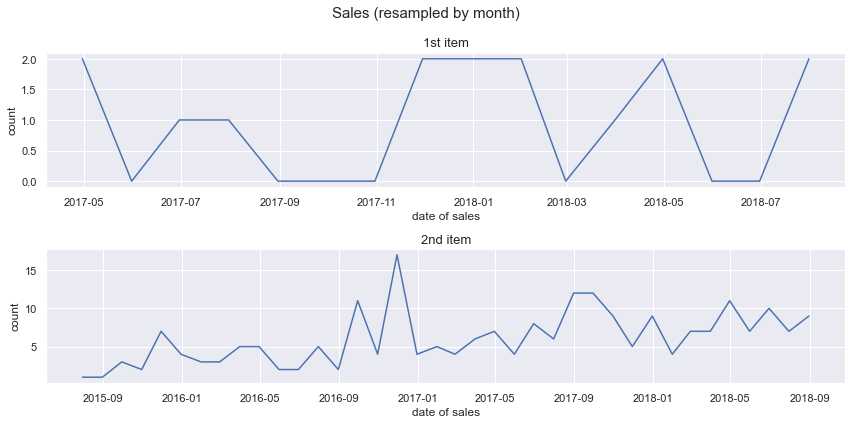

In [19]:
# plot resampled data
plot_graphs(df1=df1_resampled, df2=df2_resampled, title='Sales (resampled by month)')

In [20]:
# carry out Augmented Dickey–Fuller test (original data)
ADF_result1 = adfuller(df2_resampled['count'])
print(f'ADF Statistic: {ADF_result1[0]}')
print(f'p-value: {ADF_result1[1]}')

ADF Statistic: -2.647373350353466
p-value: 0.08359599569866033


In [21]:
# time differencing of df2 (1st order)
df2_resampled_diff = (df2_resampled - df2_resampled.shift()).fillna(method='bfill')

In [22]:
# carry out Augmented Dickey–Fuller test (1st order time differencing)
ADF_result2 = adfuller(df2_resampled_diff['count'])
print(f'ADF Statistic: {ADF_result2[0]}')
print(f'p-value: {ADF_result2[1]}')

ADF Statistic: -13.867659087749022
p-value: 6.552303614152449e-26


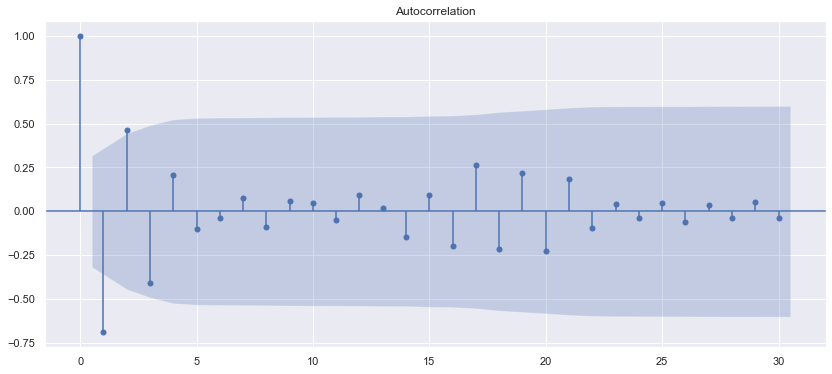

In [23]:
# plot auto-correlation between values 30 steps backward
fig, ax = plt.subplots(figsize=(14, 6))
sm.graphics.tsa.plot_acf(df2_resampled_diff['count'], lags=30, ax=ax)
plt.show()

In [24]:
# copy resampled data
df1_copy = df1_resampled.copy().reset_index()
df2_copy = df2_resampled_diff.copy().reset_index()

In [25]:
# convert to numpy array
df1_copy_np = df1_copy['count'].to_numpy().reshape(-1, 1)
df2_copy_np = df2_copy['count'].to_numpy().reshape(-1, 1)

In [26]:
# scale data in range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
y1_np = scaler.fit_transform(df1_copy_np)
y2_np = scaler.fit_transform(df2_copy_np)

In [27]:
# convert numpy array to pandas dataframe
y1_pd = pd.DataFrame(y1_np, columns=['1st_item'])
y2_pd = pd.DataFrame(y2_np, columns=['2nd_item'])

In [28]:
# create scaled datasets
df1_scaled = pd.merge(df1_copy, y1_pd, left_index=True, right_index=True)\
    .drop(['count'], axis=1)\
    .rename(columns={'1st_item': 'count'})

df2_scaled = pd.merge(df2_copy, y2_pd, left_index=True, right_index=True)\
    .drop(['count'], axis=1)\
    .rename(columns={'2nd_item': 'count'})    

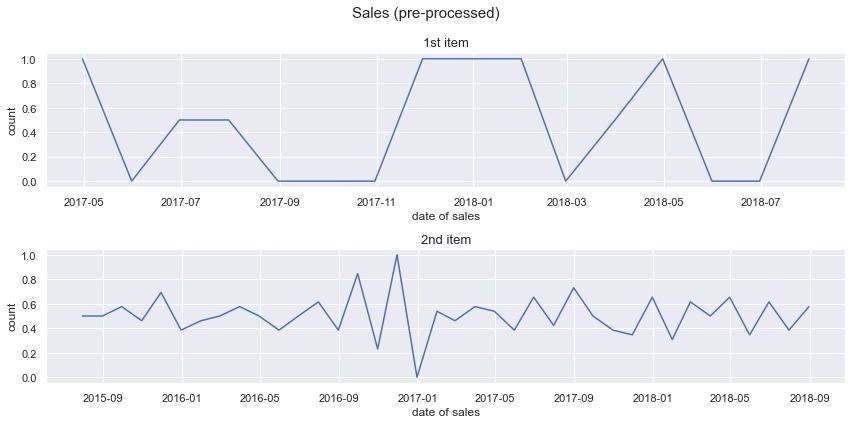

In [29]:
# plot final pre-processed data
plot_graphs(df1=df1_scaled, df2=df2_scaled, title='Sales (pre-processed)')

## Feature engineering

In [30]:
# function for making features
def make_features(df, max_lag, moving_avg_size):
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['count'].shift(lag)

    df['lag_{}_avg'.format(max_lag)] = df['count'].shift().rolling(moving_avg_size).mean()
    
    df = df.set_index('date')
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['monthday'] = df.index.day
    df['weekday'] = df.index.dayofweek

    df = df.fillna(0)
    return df

In [31]:
# print out size of datasets
print('Size of 1st dataset:', len(df1_scaled))
print('Size of 2nd dataset:', len(df2_scaled))

Size of 1st dataset: 16
Size of 2nd dataset: 38


In [32]:
# create final dataset for df1
df1_final = make_features(df=df1_scaled, max_lag=4, moving_avg_size=4)
display(df1_final.head(10))

,count,lag_1,lag_2,lag_3,lag_4,lag_4_avg,year,month,monthday,weekday
date,,,,,,,,,,
2017-04-30,1.0,0.0,0.0,0.0,0.0,0.00,2017,4,30,6
2017-05-31,0.0,1.0,0.0,0.0,0.0,0.00,2017,5,31,2
2017-06-30,0.5,0.0,1.0,0.0,0.0,0.00,2017,6,30,4
2017-07-31,0.5,0.5,0.0,1.0,0.0,0.00,2017,7,31,0
2017-08-31,0.0,0.5,0.5,0.0,1.0,0.50,2017,8,31,3
2017-09-30,0.0,0.0,0.5,0.5,0.0,0.25,2017,9,30,5
2017-10-31,0.0,0.0,0.0,0.5,0.5,0.25,2017,10,31,1
2017-11-30,1.0,0.0,0.0,0.0,0.5,0.12,2017,11,30,3
2017-12-31,1.0,1.0,0.0,0.0,0.0,0.25,2017,12,31,6


In [33]:
# create final dataset for df2
df2_final = make_features(df=df2_scaled, max_lag=4, moving_avg_size=4)
display(df2_final.head(10))

,count,lag_1,lag_2,lag_3,lag_4,lag_4_avg,year,month,monthday,weekday
date,,,,,,,,,,
2015-07-31,0.50,0.00,0.00,0.00,0.00,0.00,2015,7,31,4
2015-08-31,0.50,0.50,0.00,0.00,0.00,0.00,2015,8,31,0
2015-09-30,0.58,0.50,0.50,0.00,0.00,0.00,2015,9,30,2
2015-10-31,0.46,0.58,0.50,0.50,0.00,0.00,2015,10,31,5
2015-11-30,0.69,0.46,0.58,0.50,0.50,0.51,2015,11,30,0
2015-12-31,0.38,0.69,0.46,0.58,0.50,0.56,2015,12,31,3
2016-01-31,0.46,0.38,0.69,0.46,0.58,0.53,2016,1,31,6
2016-02-29,0.50,0.46,0.38,0.69,0.46,0.50,2016,2,29,0
2016-03-31,0.58,0.50,0.46,0.38,0.69,0.51,2016,3,31,3


## ML model

In [34]:
# hyper-parameters
SEQUENCE_LENGTH = 4
BATCH_SIZE = 4
LEARNING_RATE = 0.3
NUM_HIDDEN_UNITS = 16
NUM_EPOCHS = 80+1
PRINT_EPOCH = 20

In [35]:
# dataset for sequential data
class SequenceDataset(Dataset):
    def __init__(self, data, target, features, sequence_length):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(data[target].values).float()
        self.X = torch.tensor(data[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [36]:
# model and learning algorithm (Long short-term memory)
class RegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten() # first dim of Hn is num_layers, which is set to 1 above

        return out

In [37]:
# training process
def train_model(data_loader, model, criterion, optimizer, epochs, print_epoch):
    
    train_result = [] 
    for epoch in range(epochs):    
        iter_loss = 0  
        model.train()
        
        for i, data in enumerate(data_loader):
            X, y = data                # (predictors, targets)
            oupt = model(X)            # predicted values
            loss = criterion(oupt, y)  # mean squared error

            iter_loss += loss          # avg per item in batch

            optimizer.zero_grad()      # prepare gradients
            loss.backward()            # compute gradients
            optimizer.step()           # update weights

            if(epoch == epochs - 1):
                train_result.append((y, oupt.reshape(1, -1)[0]))

        if(epoch % print_epoch == 0):
            print('Train: epoch: {0} | loss: {1:.5f}'.format(epoch, iter_loss / (i + 1)))  

    return train_result 

In [38]:
# concatenate df1 and df2
df_final = pd.concat([df1_final, df2_final])

In [39]:
# define features and target
target = 'count'
features = list(df_final.columns.difference([target]))

In [40]:
# create dataset
dataset = SequenceDataset(
    data=df_final,
    target=target,
    features=features,
    sequence_length=SEQUENCE_LENGTH
)

In [41]:
# create dataloader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [42]:
# print out shape of features and target in dataloader
X, y = next(iter(data_loader))
print('Features shape:', X.shape)
print('Target shape:', y.shape)

Features shape: torch.Size([4, 4, 9])
Target shape: torch.Size([4])


In [43]:
# create model, loss function and optimizer
model = RegressionLSTM(num_features=len(features), hidden_units=NUM_HIDDEN_UNITS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [44]:
# train model and get results
result = train_model(
    data_loader=data_loader, 
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=NUM_EPOCHS, 
    print_epoch=PRINT_EPOCH
)

Train: epoch: 0 | loss: 0.22755
Train: epoch: 20 | loss: 0.12811
Train: epoch: 40 | loss: 0.14968
Train: epoch: 60 | loss: 0.11820
Train: epoch: 80 | loss: 0.17451


In [45]:
# extract ground truth and predictions
true, pred = zip(*result)
true, pred = torch.cat(true), torch.cat(pred)

In [46]:
# convert to pandas and merge into dataframe
true_pd = pd.DataFrame(true.numpy(), columns=['true'])
pred_pd = pd.DataFrame(pred.detach().numpy(), columns=['pred'])
result_pd = pd.merge(true_pd, pred_pd, left_index=True, right_index=True)

In [47]:
# calculate buying score
result_pd['score'] = (result_pd['pred'] + 1) / (result_pd['true'] + 1)

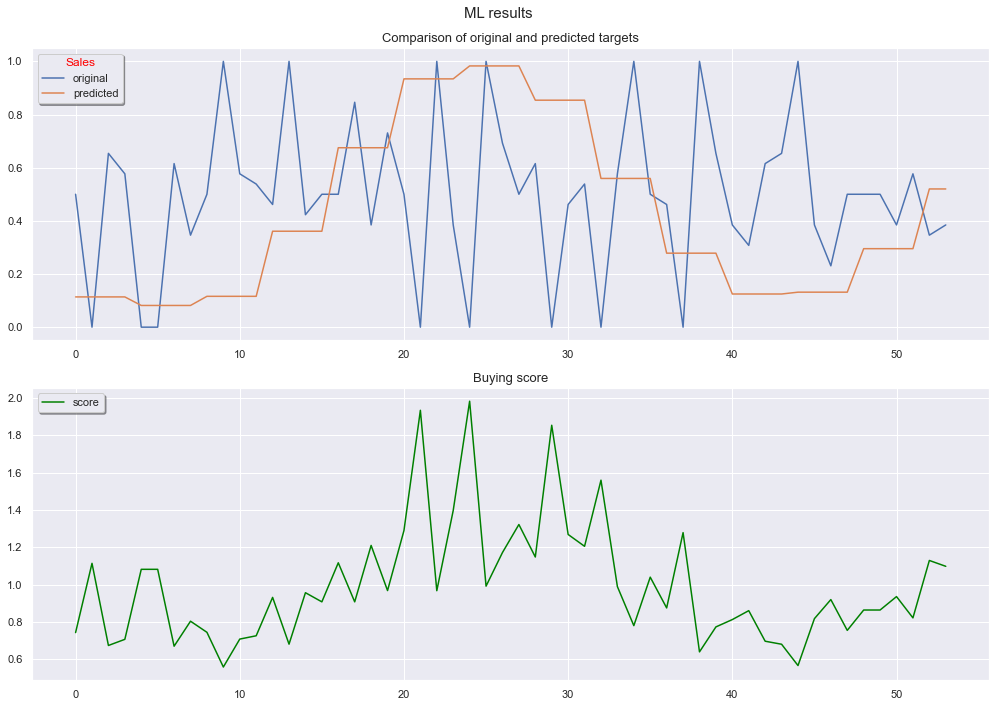

In [50]:
# plot final results
fig, (ax0, ax1) = plt.subplots(2, figsize=(14, 10))
fig.suptitle('ML results', fontsize=15)

ax0.set_title('Comparison of original and predicted targets', fontsize=13)
ax1.set_title('Buying score', fontsize=13)

ax0.plot(result_pd['true'], label='original')
ax0.plot(result_pd['pred'], label='predicted')

leg = ax0.legend(loc='upper left', shadow=True, title='Sales')
leg.get_title().set_color('red')

ax1.plot(result_pd['score'], label='score', color='green')
ax1.legend(loc='upper left', shadow=True)

plt.tight_layout()